# FDTD

### Libraries

In [27]:
import numpy as np
import math
from matplotlib import pyplot as plt 
import pandas as pd
from scipy.fft import fft, fftfreq

### Variables and constants

In [28]:
lambda_min = 8.6543*10**-2   #minimum lambda in the wavelength regime.
# lambda_max = 800*10**-9   #maximum lambda in wavelength regime.
min_lam_sf = 20     #safety factor for the min labmda.

res_sf = 4       #resolution safety factor
c0 = 299792458  #speed of light.
critic_dim = 30.48*10**-2 #a critical dimension that needs to be represented well
device_dim = critic_dim
min_dim = critic_dim
n_device = 3.46
n_bc = 1  #refractive index of boundaries
n_max = 3.46

### Grid Resolution

delta_z is the pixel length. 
delta_z_init is the minimum of two options:
a- lambda_min/safety factor
b- minimum dimension/safety factor
we initialize it and then snap the grid to the critical dimension

In [29]:
delta_z_init = min(lambda_min / min_lam_sf, min_dim / res_sf)

N = math.ceil(critic_dim/ delta_z_init)
dz = critic_dim / N
N_device = device_dim/dz  #number of grid points for the device.
N = 94

delta_z_init
dz

0.0042929577464788735

### Building device

In [30]:
# build a device
ER_yy = np.ones(N) # air
UR_xx = np.ones(N) # air and ALMOST all other materials.
"""
Device is inserted in the middle of the grid.

"""
device_start_pos =13
device_end_post = 83
ER_yy[device_start_pos : device_end_post] = 6
UR_xx[device_start_pos : device_end_post] = 2

### Visualising device

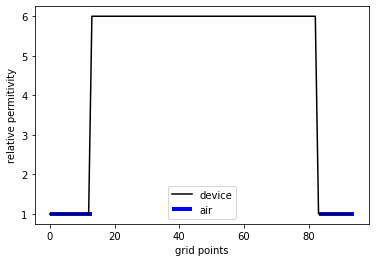

In [31]:
plt.plot(ER_yy, color = 'black', label = 'device')
plt.hlines(1, 0, device_start_pos, colors='blue', linestyles='solid', linewidth = 4, label='air')
plt.hlines(1, device_end_post, N, colors='blue', linestyles='solid', linewidth = 4)
plt.xlabel("grid points")
plt.ylabel("relative permitivity")
plt.legend()

### Time step

  time step, physical wave would not propagate further than a single unit cell in one time step.

In [32]:
dt= n_bc * dz / (2 * c0)  # Courant condition.
dt

7.159882832140616e-12

### Source

Since fmax = 1/pi.taw --> taw =~ 0.5/fmax.
The pulse source must start at zero and gradually increase. NO STEP FUNCTIONS

In [33]:
f_max = 10**9
taw = 0.5 / f_max
#taw = 0.5
t0 = 6 * taw
def g(t):
    """
    g(t): Gaussian source function
    """
    return   np.exp(-((t -  t0) / taw)**2)   
taw

5e-10

### TFSF

TFSF separates the total field and the scattered field into two separate regions. This is particularly useful for creating a one-way source, and for calculating the transmission and reflection spectra. 

In the separation, the equations should be adjusted because of the finite differencing, we have some points at the total field that take the field value of the scattered field and vice versa. 

In [34]:
f_max = c0 / lambda_min
taw = 0.5 / f_max
t0 = 6 * taw
def Ey_src(t):
    """
    g(t): Gaussian source function
    """
    return   np.exp(-((t -  t0)/taw)**2)   



A = -1
dt_src = (dt/2) + dz/(2*c0)
def Hx_src(t):
    """
    g(t): Gaussian source function
    """
    
    return   A*np.exp(-((t-t0+dt_src) / taw)**2)   
    

dt_src

1.0739824248210925e-11

### Computations

Update coefficients are constants that will be used in the code below continiously, to save computation time, we calculate them once.

In [35]:
# Update coefficients
mEy = c0 * dt / ER_yy
mHx = c0 * dt / UR_xx
# initialize fields
Ey = np.zeros(N)
Hx = np.zeros(N)

### Magnetic Field Normalization

The divergence equations were satisfied by adopting the Yee grid scheme. Now, only the the
curl equations have to be dealt with.
The 𝐸 and 𝐻 fields are related through the impedance of the material they are in, so they are
roughly three orders of magnitude different.

This may cause rounding errors in simulation and it is always good practice to normalize
parameters so they are all the same order of magnitude. Here, the magnetic field is
normalized

Normalization: H_tilde = eta_0 * H, eta_0 = 300

### Calculating number of time steps

How long does it take a wave to propagate across the grid (worst case)?

Simulation time T must include the entire pulse of duration.
Simulation time should allow for 5 bounces.

A rule-of-thumb for total simulation time is then 5 t_prop + 12 * taw.

In [36]:
t_prop = n_max * N * dz / c0
T = 12*taw + 5* t_prop
STEPS = 4095

In [37]:
Ey_t = np.zeros([STEPS, N]) #time evolution of the fields

In [38]:
# MAIN FDTD LOOP with perfect boundary conditions
H1 = 0
H2 = 0
E1 = 0
E2 = 0
nzsrc = 10
    
Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
for T in range(STEPS):        
    #Update H from E
    #modificaion
    H2=H1
    H1=Hx[0]
    for nz in range(N-1):
        Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
        Hx_t[T][nz] = Hx[nz] #recording field as a matrix
    Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
    # E2 = the field at the second last point of the grid two time steps earlier.
    Hx[nzsrc-1] = Hx[nzsrc-1]\
    -(Ey_src(T*dt) * mHx[nzsrc]/dz) #update equation with correction term of the TF/SF
#     Hx[nzsrc-1] = Hx[nzsrc-1] + mHx[nzsrc-1]*\
#     (Ey[nzsrc] - Ey[nzsrc-1])/dz-(Ey_src(T*dt) * mHx[nzsrc-1]/dz) #update equation with 
#     # correction term of the TF/SF
    
    
            
    Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
    #Update E from H
    #modification
    E2=E1
    E1=Ey[N-1]
    Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

    Ey_t[T][0] = Ey[0]
    
    for nz in range(1, N):
        Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz
                    
        Ey_t[T][nz] = Ey[nz] #recording field as a matrix
        
    Ey[nzsrc] = Ey[nzsrc]\
    - Hx_src(T*dt) * mEy[nzsrc-1]/dz   


In [39]:
x = np.array([1,2,3]).astype(complex)
x[:2] = np.array([1+2j, 1-2j])
x

array([1.+2.j, 1.-2.j, 3.+0.j])

Below is a simple source.

In [40]:
# # MAIN FDTD LOOP with perfect boundary conditions
# H1 = 0
# H2 = 0
# E1 = 0
# E2 = 0


# Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.

# for T in range(STEPS):        
#     #Update H from E
#     #modificaion
#     H2=H1
#     H1=Hx[0]
#     for nz in range(N-1):
#             Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
#             Hx_t[T][nz] = Hx[nz] #recording field as a matrix
#     Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
#     # E2 = the field at the second last point of the grid two time steps earlier.

#     Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
#     #Update E from H
#     #modification
#     E2=E1
#     E1=Ey[N-1]
#     Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

#     Ey_t[T][0] = Ey[0]
    
#     for nz in range(1, N):
#             Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz 
            
#             Ey_t[T][nz] = Ey[nz] #recording field as a matrix
            
#     Ey[2] = Ey[2] +g(T*dt)  # Simple source, gE is stored in an array of length STEPS    
#     #Ey[10] = g(T*dt)

In [41]:
#Denormalization of H field: would be hard to visualize.
# eta_0 = 300
# Hx_t =  Hx_t/eta_0
    

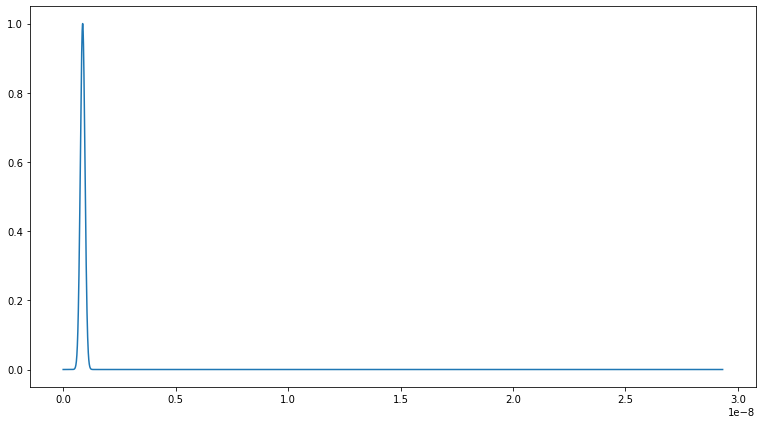

In [42]:
#Source, and fourier transforming:

time_stamps = np.linspace(0, STEPS*dt, STEPS)
N_time_stamps = time_stamps.shape[0]
time_spacing= dt
freqs = fftfreq(N_time_stamps, time_spacing)

Ey_src_vectorized = np.vectorize(Ey_src)
Source_T = []
for T in range(STEPS):
    Source_T.append(Ey_src_vectorized(T*dt))
Source_F = fft(Source_T)
plt.figure(figsize=(13,7))
plt.plot(time_stamps, Source_T)
plt.show()

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text major ticklabel objects>)

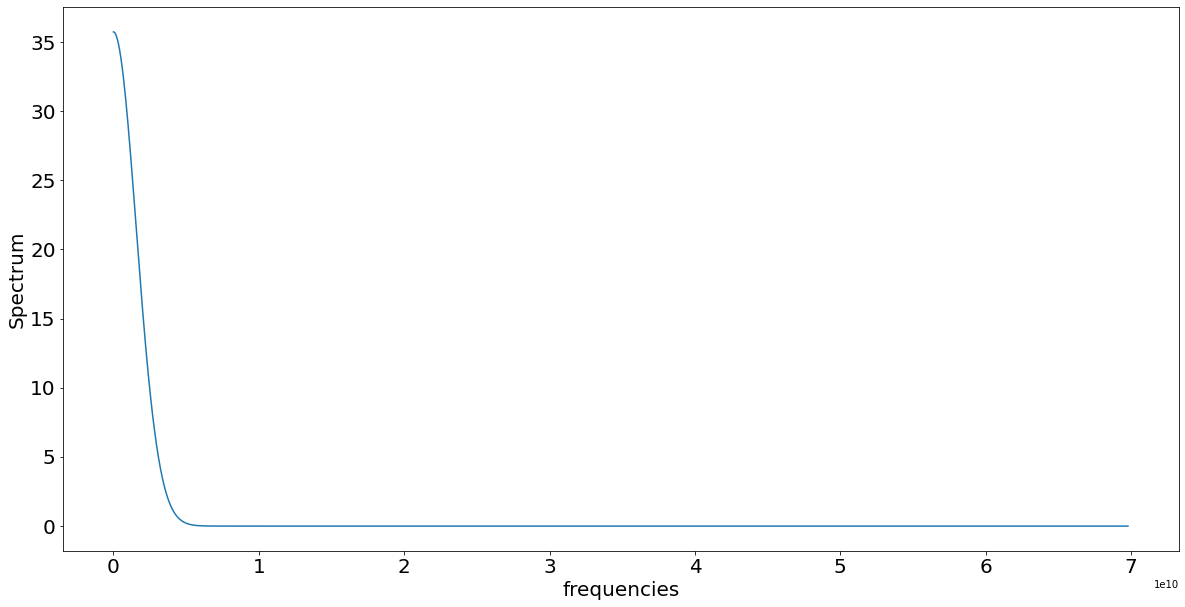

In [43]:
plt.figure(figsize=(20,10))
source_pos = np.abs(Source_F)[0:int(freqs.shape[0]/2)].reshape(-1,1)
plt.plot(freqs[0:int(freqs.shape[0]/2)],source_pos )
plt.xlabel("frequencies", fontsize = 20)
plt.ylabel("Spectrum", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

In [47]:
cell_number = N-1
last_field = Ey_t[:, cell_number].reshape(-1,1)
first_field = Ey_t[:, 0].reshape(-1,1)

plt.figure(figsize=(20,10))
T = fft(last_field)
R= fft(first_field)
plt.show()

<Figure size 1440x720 with 0 Axes>

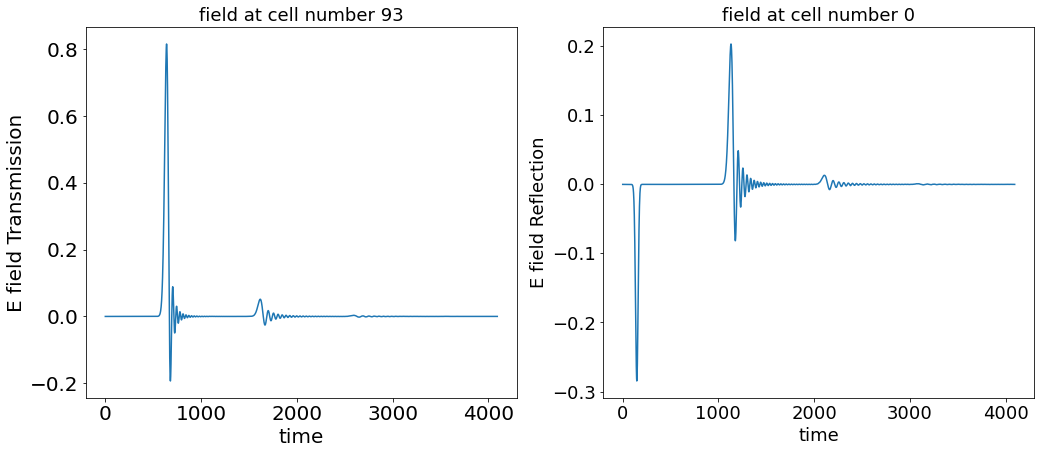

In [48]:

cell_number = N-1
plt.figure(figsize=(17,15))
plt.subplot(221)
plt.plot(Ey_t[:, cell_number]) #field at 
plt.title("field at cell number " +str(cell_number), fontsize = 18)


plt.xlabel("time", fontsize = 20)
plt.ylabel("E field Transmission", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


cell_number = 0
plt.subplot(222)
plt.plot(Ey_t[:, cell_number]) #field at 
plt.title("field at cell number " +str(cell_number), fontsize = 18)

plt.xlabel("time", fontsize = 18)
plt.ylabel("E field Reflection", fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)



plt.show()

Text(0.5, 1.0, 'field at cell number 0')

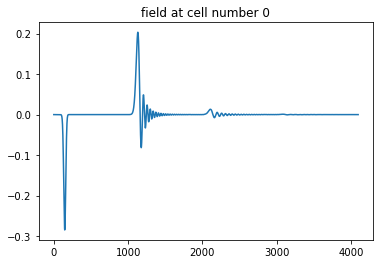

In [49]:
cell_number = 0
plt.plot(Ey_t[:, cell_number]) #field at 
plt.title("field at cell number " +str(cell_number))


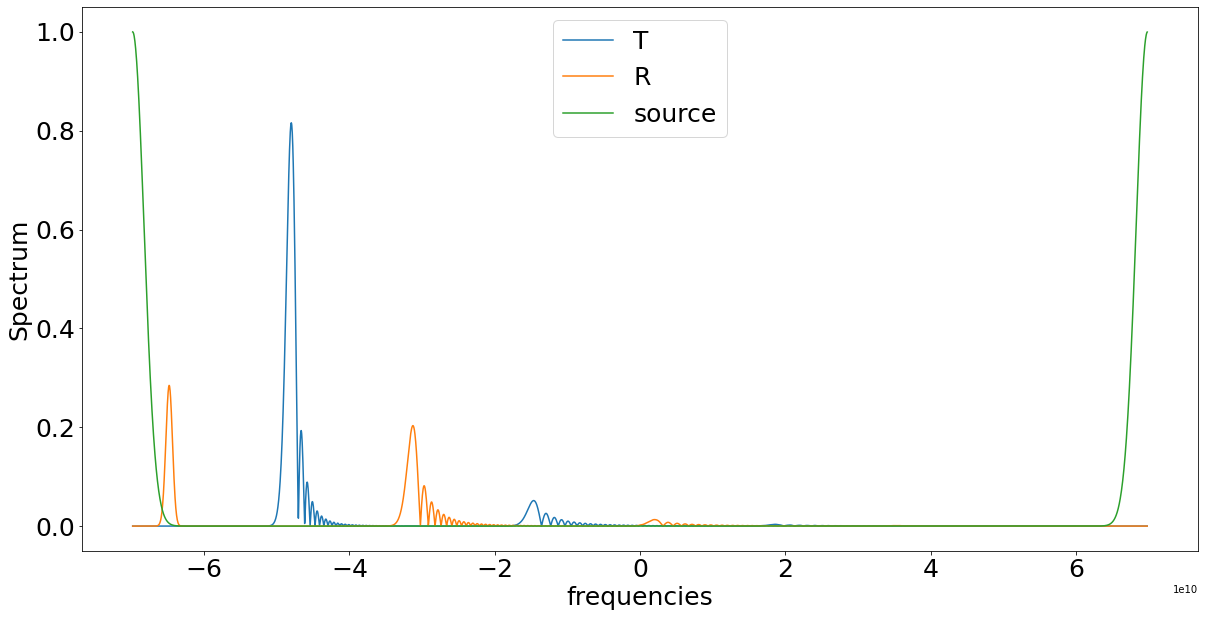

In [121]:
from scipy.fft import fft, fftfreq

last_field = Ey_t[:, N-1].reshape(-1,1)
first_field = Ey_t[:, 0].reshape(-1,1)
time_stamps = np.linspace(0, STEPS*dt, STEPS)
N_time_stamps = STEPS

freqs = fftfreq(N_time_stamps, dt) 
f_shifted = np.fft.fftshift(freqs)

plt.figure(figsize=(20,10))

last_field_F = fft(last_field)
first_field_F= fft(first_field)

freq_pos = freqs
last_field_F_pos = np.abs(last_field_F)
first_field_F_pos = np.abs(first_field_F)
source_pos = np.abs(Source_F).reshape(-1,1)


plt.plot(f_shifted, last_field_F_pos, label = "T")
plt.plot(f_shifted,first_field_F_pos , label = "R")
plt.plot(f_shifted, source_pos/max(source_pos), label = "source")
plt.legend(fontsize = 25, loc='best')
plt.xlabel("frequencies", fontsize = 25)
plt.ylabel("Spectrum", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.show()
#plt.plot(freq_pos, source_pos/max(source_pos), label = "source")


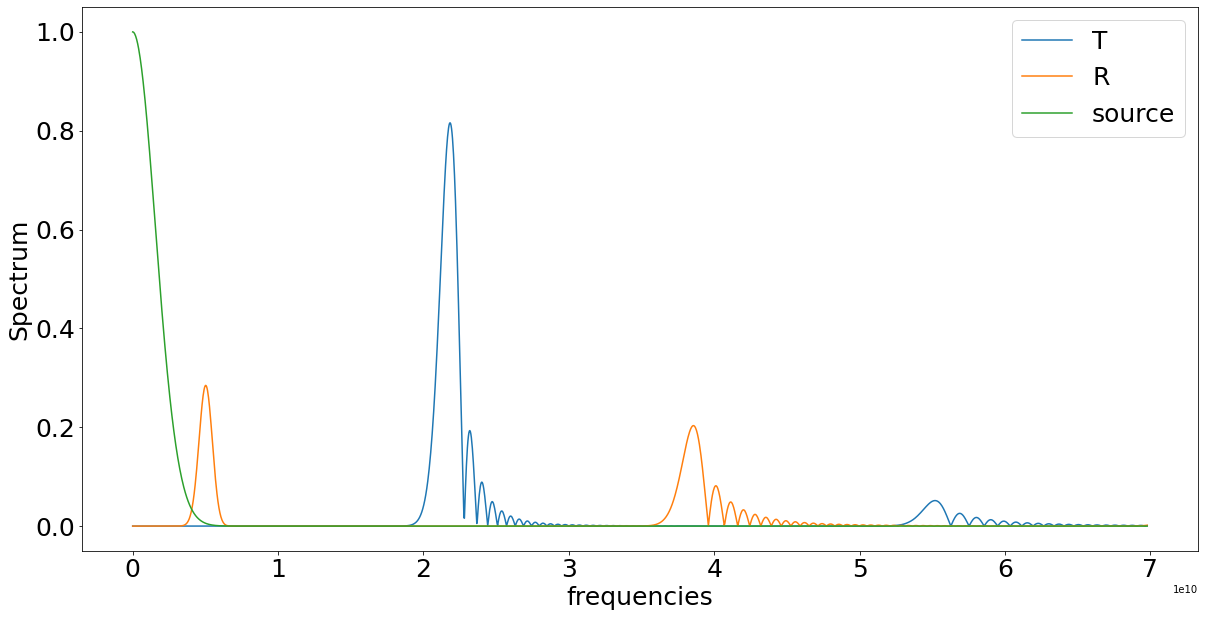

In [105]:
#FFT of the last cell --> Transmission
from scipy.fft import fft, fftfreq


last_field = Ey_t[:, N-1].reshape(-1,1)
first_field = Ey_t[:, 0].reshape(-1,1)
time_stamps = np.linspace(0, STEPS*dt, STEPS)
N_time_stamps = STEPS
time_spacing= dt
freqs = fftfreq(N_time_stamps, time_spacing)
plt.figure(figsize=(20,10))
last_field_F = fft(last_field)
first_field_F= fft(first_field)
freq_pos = freqs[0:int(freqs.shape[0]/2)]
last_field_F_pos = np.abs(last_field_F)[0:int(freqs.shape[0]/2)]
first_field_F_pos = np.abs(first_field_F)[0:int(freqs.shape[0]/2)]


CON_pos = last_field_F_pos + first_field_F_pos
plt.plot(freq_pos, last_field_F_pos, label = "T")
plt.plot(freq_pos,first_field_F_pos , label = "R")
plt.plot(freq_pos, source_pos/max(source_pos), label = "source")

#plt.plot(freq_pos, CON, 'ro', label = "CON")
#plt.plot(freqs, np.abs(T), label = "T")
#plt.plot(freqs, np.abs(R), label = "R")
#plt.scatter(freqs, np.abs(T)  + abs(R), label = "CON")
plt.legend(fontsize = 25, loc='best')
plt.xlabel("frequencies", fontsize = 25)
plt.ylabel("Spectrum", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.show()


In [53]:
#plots normalized:


# plt.plot(freq_pos, T_pos/(source_pos), label = "T")
# plt.plot(freq_pos,R_pos/(source_pos) , label = "R")
# plt.plot(freq_pos, CON/(source_pos), 'ro', label = "CON")
# plt.legend()

In [86]:
z_axis = np.linspace(0, dz*N, N)
z_axis.shape

(94,)

Text(0.5, 1.0, 'field at time step 300')

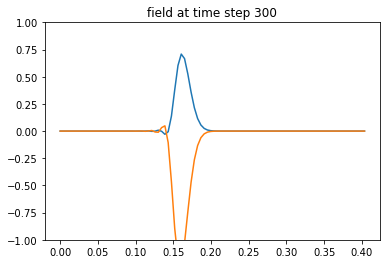

In [98]:
time_step = 300
%matplotlib inline
plt.plot(z_axis, Ey_t[time_step, :], label = "E") 
plt.plot(z_axis, Hx_t[time_step, :], label = "H") 
plt.ylim(top=1)  # adjust the top leaving bottom unchanged
plt.ylim(bottom=-1)  # adjust the bottom leaving top unchanged
plt.title("field at time step " +str(time_step))

# this is our frame Ey_t[time_step, :]


In [56]:
Ey_t

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.33222720e-06, -1.14605589e-05, -2.91117918e-05, ...,
         7.10743875e-05,  8.54290345e-05,  8.73921059e-05],
       [-2.76650111e-06, -2.02864549e-05, -3.74207449e-05, ...,
         6.04901991e-05,  7.97562623e-05,  8.81736908e-05],
       [-1.13446861e-05, -2.90159349e-05, -4.49317412e-05, ...,
         4.82703513e-05,  7.13713314e-05,  8.55959561e-05]])

Text(0.5, 1.0, 'field at time step 40')

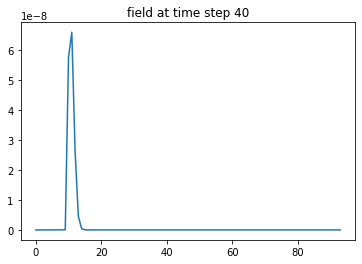

In [57]:
time_step = 40
%matplotlib inline
plt.plot(Ey_t[time_step, :]) 
plt.title("field at time step " +str(time_step))

# this is our frame Ey_t[time_step, :]


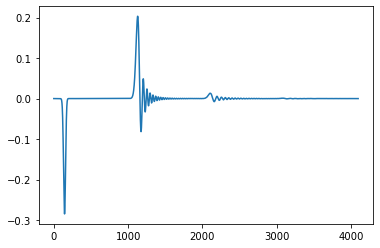

In [58]:
plt.plot(Hx_t[:, 1])

### Creating animation for the fields evolutions

In [59]:
%matplotlib nbagg

In [60]:
%matplotlib inline

In [61]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
Edata = Ey_t
Hdata = Hx_t
# save to csv file
savetxt('Edata.csv', Edata, delimiter=',')
savetxt('Hdata.csv', Hdata, delimiter=',')

In [62]:
Efield = pd.read_csv('Edata.csv')
Hfield = pd.read_csv('Hdata.csv')


In [63]:
# for i in Efield.shape[0]:
#     if 

In [64]:
Efield

,0.000000000000000000e+00,0.000000000000000000e+00.1,0.000000000000000000e+00.2,0.000000000000000000e+00.3,0.000000000000000000e+00.4,0.000000000000000000e+00.5,0.000000000000000000e+00.6,0.000000000000000000e+00.7,0.000000000000000000e+00.8,-5.798807075608924085e-17,...,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88,0.000000000000000000e+00.89,0.000000000000000000e+00.90,0.000000000000000000e+00.91
0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.449702e-17,-1.069705e-16,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-3.624254e-18,-4.848816e-17,-8.892710e-17,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-9.060636e-19,-1.755842e-17,-8.137305e-17,-7.384350e-18,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.265159e-19,-5.748701e-18,-4.328316e-17,-7.980712e-17,7.834055e-17,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,-5.662898e-20,-1.776949e-18,-1.859441e-17,-6.875527e-17,-2.957327e-17,1.104700e-16,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4089,0.000019,0.000005,-0.000012,-0.000029,-4.504180e-05,-5.633885e-05,-6.080236e-05,-5.739236e-05,-4.668144e-05,-3.087763e-05,...,-0.000048,-0.000041,-0.000027,-0.000006,0.000020,0.000048,0.000071,0.000085,0.000087,0.000076
4090,0.000013,-0.000003,-0.000020,-0.000037,-5.139691e-05,-5.950120e-05,-6.007594e-05,-5.285843e-05,-3.925866e-05,-2.217769e-05,...,-0.000048,-0.000046,-0.000035,-0.000017,0.000007,0.000034,0.000060,0.000079,0.000088,0.000083
4091,0.000005,-0.000011,-0.000029,-0.000045,-5.629819e-05,-6.078117e-05,-5.740146e-05,-4.672894e-05,-3.096558e-05,-1.356610e-05,...,-0.000047,-0.000048,-0.000042,-0.000027,-0.000006,0.000021,0.000048,0.000071,0.000085,0.000087
4092,-0.000003,-0.000020,-0.000037,-0.000051,-5.949367e-05,-6.009546e-05,-5.290377e-05,-3.932673e-05,-2.226347e-05,-5.546320e-06,...,-0.000045,-0.000049,-0.000046,-0.000035,-0.000017,0.000007,0.000035,0.000060,0.000080,0.000088


In [65]:
STEPS

4095

In [66]:
!cd

C:\Users\Ahmed
